### Tutors - expected math exam results
__Predict average math exam results for students of the tutors__  
https://www.kaggle.com/c/tutors-expected-math-exam-results

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
TRAIN_DATASET_PATH = './datasets/train.csv'
TEST_DADASET_PATH = './datasets/test.csv'

In [3]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)

In [4]:
train_df.head()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
0,0,40.0,0.0,1400.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,63.0
1,1,48.0,4.0,2850.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,86.0
2,2,39.0,0.0,1200.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0
3,3,46.0,5.0,1400.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0
4,4,43.0,1.0,1500.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0


In [5]:
train_df.tail()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
9995,9995,44.0,0.0,1700.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,78.0
9996,9996,51.0,0.0,1700.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,64.0
9997,9997,34.0,1.0,1250.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,58.0
9998,9998,33.0,3.0,1100.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,51.0
9999,9999,35.0,0.0,1450.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   10000 non-null  int64  
 1   age                  10000 non-null  float64
 2   years_of_experience  10000 non-null  float64
 3   lesson_price         10000 non-null  float64
 4   qualification        10000 non-null  float64
 5   physics              10000 non-null  float64
 6   chemistry            10000 non-null  float64
 7   biology              10000 non-null  float64
 8   english              10000 non-null  float64
 9   geography            10000 non-null  float64
 10  history              10000 non-null  float64
 11  mean_exam_points     10000 non-null  float64
dtypes: float64(11), int64(1)
memory usage: 937.6 KB


In [7]:
train_df.describe()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4999.50000,45.878000,1.986800,1699.105000,1.719500,0.375000,0.132900,0.109600,0.053700,0.032100,0.019400,64.340800
std,2886.89568,8.043929,1.772213,524.886654,0.792264,0.484147,0.339484,0.312406,0.225436,0.176274,0.137933,13.536823
min,0.00000,23.000000,0.000000,200.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32.000000
25%,2499.75000,40.000000,0.000000,1300.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,55.000000
50%,4999.50000,46.000000,2.000000,1500.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,63.000000
75%,7499.25000,51.000000,3.000000,2150.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,73.000000
max,9999.00000,68.000000,10.000000,3950.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000


<AxesSubplot:>

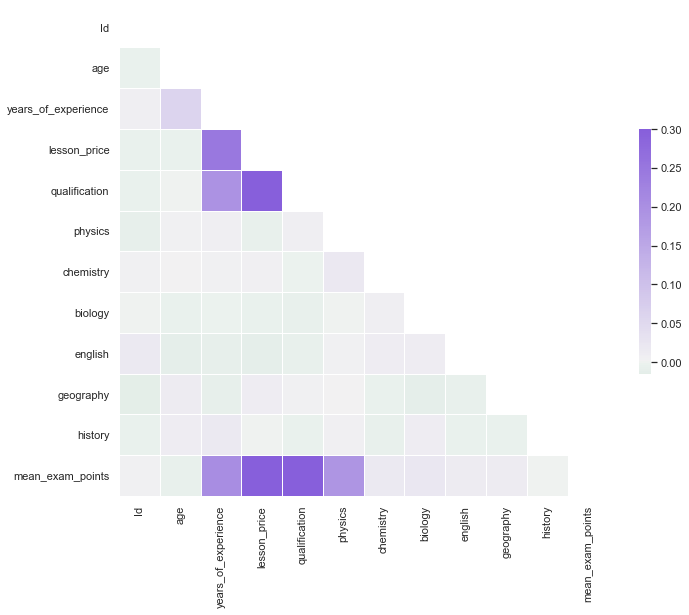

In [8]:
# Compute the correlation matrix
df_corr = train_df.corr()

sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(df_corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(150, 275, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df_corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Т.к. признаки years_of_experience, lesson_price и qualification имеют сильную кореляцию между собой, применяю метод главных компонент

In [9]:
class PCA():
    
    def fit(self, data):
        # нормирую данные
        data_ = data.astype(float)
        mean=np.apply_along_axis(np.mean, 0, data)
        std=np.apply_along_axis(np.std, 0, data)
        data_normed=(data-mean[np.newaxis, :])/std[np.newaxis, :]

        # Найдем собственные векторы и собственные значения
        covariance_matrix = data_normed.T.dot(data_normed)
        eig_values, eig_vectors = np.linalg.eig(covariance_matrix)

        # сформируем список кортежей (собственное значение, собственный вектор)
        eig_pairs = [(np.abs(eig_values[i]), eig_vectors[:, i]) for i in range(len(eig_values))]

        # и отсортируем список по убыванию собственных значений
        eig_pairs.sort(key=lambda x: x[0], reverse=True)

        eig_sum = sum(eig_values)
        var_exp = [(i / eig_sum) * 100 for i in sorted(eig_values, reverse=True)]
        cum_var_exp = np.cumsum(var_exp)
        print(f'Доля дисперсии, описвыаемая каждой из компонент \n{var_exp}')
        
        self.data = data_
        self.eig_pairs = eig_pairs
    
    def get_components(self, n_components):
        W = np.hstack(([self.eig_pairs[j][1].reshape(self.data.shape[1],1) for j in range(n_components)]))
        return self.data.dot(W)

In [10]:
columns_to_pca = ['years_of_experience', 'lesson_price', 'qualification']

In [11]:
pca = PCA()
pca.fit(train_df[columns_to_pca])

Доля дисперсии, описвыаемая каждой из компонент 
[63.3014702293449, 29.76850959608475, 6.930020174570359]


In [12]:
train_pca = pca.get_components(2)

Добавляю новый признак

In [ ]:
# # Средняя стоимость занятия, сгрупированная по квалификации
# mean_lesson_price_by_qualification = train_df.groupby(['age', 'qualification'], as_index=False).agg({'lesson_price':'mean'})\
#                        .rename(columns={'lesson_price':'mean_lesson_price_by_qualification'})
# mean_lesson_price_by_qualification.head()

In [ ]:
# train_df = train_df.merge(mean_lesson_price_by_qualification, on=['age', 'qualification'], how='left')
# train_df.head()

In [ ]:
# # Добавляю новый бинарный столбец в котором значение равно 1, если стоимость урока выше средней в данной квалификации
# train_df['is_expensive_price'] = 0
# for i in np.unique(train_df.qualification):
#      train_df.loc[train_df.qualification == i, 'is_expensive_price'] = np.where(
#          train_df.loc[train_df.qualification == i, 'lesson_price'] >= mean_lesson_price_by_qualification[i - 1], 1, 0)

In [13]:
mean_exam_points_by_qualification = train_df.groupby(['age', 'qualification'], as_index=False).agg({'mean_exam_points':'median'})\
                       .rename(columns={'mean_exam_points':'mean_exam_points_by_qualification'})
mean_exam_points_by_qualification.head()

,age,qualification,mean_exam_points_by_qualification
0,23.0,1.0,58.0
1,23.0,2.0,67.0
2,23.0,3.0,89.0
3,24.0,1.0,65.0
4,24.0,2.0,72.5


In [14]:
train_df = train_df.merge(mean_exam_points_by_qualification, on=['age', 'qualification'], how='left')
train_df.head()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,mean_exam_points_by_qualification
0,0,40.0,0.0,1400.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,63.0,58.0
1,1,48.0,4.0,2850.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,86.0,83.0
2,2,39.0,0.0,1200.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,58.0
3,3,46.0,5.0,1400.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0,58.0
4,4,43.0,1.0,1500.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0,55.0


In [15]:
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле
        

class Leaf:

    def __init__(self, data, target_values):
        self.data = data
        self.target_values = target_values
        self.prediction = self.predict()

    def predict(self):
        return np.mean(self.target_values)

In [16]:
class DecisionTreeRegressor:
    
    def __init__(self, max_depth):
        self.max_depth = max_depth
        self.tree = None
        
    def _H(self, target_values):
        return np.var(target_values)

    def _quality(self, left_target_values, right_target_values, current_H):
        p = float(left_target_values.shape[0]) / (left_target_values.shape[0] + right_target_values.shape[0])
        return current_H - p * self._H(left_target_values) - (1 - p) * self._H(right_target_values)

    def _split(self, data, target_values, index, t):

        left = np.where(data[:, index] <= t)
        right = np.where(data[:, index] > t)

        true_data = data[left]
        false_data = data[right]
        true_target_values = target_values[left]
        false_target_values = target_values[right]

        return true_data, false_data, true_target_values, false_target_values
    
#     def _get_subsample(self, len_sample):
#         sample_indexes = [i for i in range(len_sample)]

#         len_subsample = int(np.sqrt(len_sample))
#         subsample = []

#         np.random.shuffle(sample_indexes)
#         for _ in range(len_subsample):
#             subsample.append(sample_indexes.pop())

#         return subsample

    def _find_best_split(self, data, target_values):

        #  обозначим минимальное количество объектов в узле
        min_leaf = 5

        current_H = self._H(target_values)

        best_quality = 0
        best_t = None
        best_index = None

        n_features = data.shape[1]
        
#         subsample = self._get_subsample(n_features)

#         for index in subsample:
        for index in range(n_features):
            # будем проверять только уникальные значения признака, исключая повторения
            t_values = np.unique([row[index] for row in data])

            for t in t_values:
                true_data, false_data, true_target_values, false_target_values = self._split(data, target_values, index, t)
                #  пропускаем разбиения, в которых в узле остается менее 5 объектов
                if len(true_data) < min_leaf or len(false_data) < min_leaf:
                    continue

                current_quality = self._quality(true_target_values, false_target_values, current_H)

                #  выбираем порог, на котором получается максимальный прирост качества
                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, index

        return best_quality, best_t, best_index

    def _build_tree(self, data, target_values, current_depth):
        
        if current_depth > self.max_depth:
            return Leaf(data, target_values)
        
        current_depth += 1
        
        quality, t, index = self._find_best_split(data, target_values)

        #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
        if quality == 0:
            return Leaf(data, target_values)

        true_data, false_data, true_target_values, false_target_values = self._split(data, target_values, index, t)

        # Рекурсивно строим два поддерева
        true_branch = self._build_tree(true_data, true_target_values, current_depth)
        false_branch = self._build_tree(false_data, false_target_values, current_depth)
    
        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
        return Node(index, t, true_branch, false_branch)
        
    def build(self, data, target_values, max_depth=None):
        self.tree = self._build_tree(data, target_values, 0)

    def _predict(self, obj, node):

        #  Останавливаем рекурсию, если достигли листа
        if isinstance(node, Leaf):
            answer = node.prediction
            return answer

        if obj[node.index] <= node.t:
            return self._predict(obj, node.true_branch)
        else:
            return self._predict(obj, node.false_branch)

    def predict(self, data):

        predicted_values = []
        for obj in data:
            prediction = self._predict(obj, self.tree)
            predicted_values.append(prediction)
        return predicted_values

In [17]:
class GradientBoosting:
    
    def __init__(self, n_trees, coef, max_depth, alpha):
        self.n_trees = n_trees
        self.coefs = [coef] * n_trees
        self.max_depth = max_depth
        self.alpha = alpha
        self.trees = []
        
    np.random.seed(27)

    def _get_bootstrap(self, X, y):
        n_samples = X.shape[0]
        bootstrap = []
        for i in range(self.n_trees):
            indexes=np.random.randint(0, n_samples-1, size=y.shape)
            bootstrap.append((X[indexes, :], y[indexes]))
        return bootstrap
    
    @staticmethod
    def bias(y, z):
        return 2 * (y - z)
    
    def fit(self, X, y):
        
        bootstrap = self._get_bootstrap(X, y)
        
        for X_bt, y_bt in bootstrap:
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            
            # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
            # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
            if len(self.trees) == 0:
                # обучаем первое дерево на обучающей выборке
                tree.build(X_bt, y_bt)

            else:
                # Получим ответы на текущей композиции
                target = self.predict(X_bt)

                # алгоритмы начиная со второго обучаем на сдвиг
                tree.build(X_bt, self.bias(y_bt, target))

            self.trees.append(tree)
        
    def predict(self, X):
        # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
        # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
        return np.array([sum([self.alpha * coef * model.predict([x])[0] for model, coef in 
                              zip(self.trees, self.coefs)]) for x in X])

In [18]:
class GradientBoosting_v2:
    
    def __init__(self, n_trees, coefs, max_depth, alpha):
        self.n_trees = n_trees
        self.coefs = coefs
        self.max_depth = max_depth
        self.alpha = alpha
        self.trees = []
        
    np.random.seed(27)
    
    @staticmethod
    def bias(y, z):
        return 2 * (y - z)
    
    def fit(self, X, y):
                
        for i in range(self.n_trees):
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            
            X_bt, y_bt = bootstrap[i]
            
            # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
            # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
            if len(self.trees) == 0:
                # обучаем первое дерево на обучающей выборке
                tree.build(X, y)

            else:
                # Получим ответы на текущей композиции
                target = self.predict(X)

                # алгоритмы начиная со второго обучаем на сдвиг
                tree.build(X, self.bias(y, target))

            self.trees.append(tree)
        
    def predict(self, X):
        # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
        # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
        return np.array([sum([self.alpha * coef * model.predict([x])[0] for model, coef in 
                              zip(self.trees, self.coefs)]) for x in X])

In [ ]:
# def r_squared_score(y_true, y_pred):
#         corr_matrix = np.corrcoef(y_true, y_pred)
#         corr = corr_matrix[0,1]
#         return corr**2

In [19]:
def r_square(y, y_real):
    ss_total=np.sum((y_real-np.mean(y_real))**2)
    ss_res=np.sum((y_real-y)**2)
    return 1-ss_res/ss_total

In [20]:
def normalized(data, col_ids=None):
    means = np.mean(data, axis=0)
    stds = np.std(data, axis=0)
    if col_ids is None:
        col_ids = range(data.shape[1])
    
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if j in col_ids:
                data[i][j] = (data[i][j] - means[j])/stds[j]
            else:
                data[i][j] = data[i][j]
    return data

In [21]:
# Разбиваю обучающий датасет на X и y. Представляю их в формате numpy array 
X = train_df.drop(['Id', 'mean_exam_points', 'years_of_experience', 'lesson_price', 'qualification'], axis=1).values
y = train_df['mean_exam_points'].values

In [22]:
# добавляю две главные компоненты к X
X = np.hstack((X, train_pca.values))

In [23]:
# Признаки, которые буду нормализовывать
columns_ids_to_normalized = [0, 7, 8, 9]

In [24]:
X = normalized(X, columns_ids_to_normalized)

In [25]:
X[0]

array([-0.73077401,  1.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        , -0.68381778, -0.57216756,  0.5547401 ])

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=27)

In [35]:
# Число деревьев в ансамбле
n_trees = 100

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 20

# Шаг
alpha = 0.1

In [36]:
params = {'n_trees': [100, 150, 200], 'coef': [1], 'max_depth': [5, 10], 'alpha': [0.1, 0.01]}

In [37]:
def parameters_selection(train_data, train_target, test_data, test_target, params):
    result_list = []
    for n_trees in params['n_trees']:
        for coef in params['coef']:
            for max_depth in params['max_depth']:
                for alpha in params['alpha']:
                    model = GradientBoosting(n_trees=n_trees, coef=coef, max_depth=max_depth, alpha=alpha)
                    model.fit(train_data, train_target)
                    train_preds = model.predict(train_data)
                    train_score = r_square(train_preds, train_target)
                    test_preds = model.predict(test_data)
                    test_score = r_square(test_preds, test_target)
                    result_list.append({'parameters': {'n_trees': n_trees, 'coef': coef, 'max_depth': max_depth, 'alpha': alpha},
                                      'train_score': train_score, 'test_score': test_score})
    return result_list

In [38]:
best_params = parameters_selection(X_train, y_train, X_test, y_test, params)

In [39]:
import json
with open('params.json', 'w', encoding='utf-8') as f:
    json.dump(best_params, f, sort_keys=True, indent=4, ensure_ascii=False)

In [40]:
best_params

[{'parameters': {'n_trees': 100, 'coef': 1, 'max_depth': 5, 'alpha': 0.1},
  'train_score': 0.8656729805353374,
  'test_score': 0.7524224886595586},
 {'parameters': {'n_trees': 100, 'coef': 1, 'max_depth': 5, 'alpha': 0.01},
  'train_score': 0.3745802079639794,
  'test_score': 0.3850163058961763},
 {'parameters': {'n_trees': 100, 'coef': 1, 'max_depth': 10, 'alpha': 0.1},
  'train_score': 0.9523149918373826,
  'test_score': 0.6824057688742108},
 {'parameters': {'n_trees': 100, 'coef': 1, 'max_depth': 10, 'alpha': 0.01},
  'train_score': 0.44186846211878317,
  'test_score': 0.37832727391391163},
 {'parameters': {'n_trees': 150, 'coef': 1, 'max_depth': 5, 'alpha': 0.1},
  'train_score': 0.8849240617843873,
  'test_score': 0.7384752073996305},
 {'parameters': {'n_trees': 150, 'coef': 1, 'max_depth': 5, 'alpha': 0.01},
  'train_score': 0.7508335155565384,
  'test_score': 0.7323264076332865},
 {'parameters': {'n_trees': 150, 'coef': 1, 'max_depth': 10, 'alpha': 0.1},
  'train_score': 0.9616

In [36]:
gb_model = GradientBoosting(n_trees=n_trees, coefs=coefs, max_depth=max_depth, alpha=alpha)
gb_model_2 = GradientBoosting_v2(n_trees=n_trees, coefs=coefs, max_depth=max_depth, alpha=alpha)

In [37]:
gb_model.fit(X_train, y_train)

In [38]:
y_train_preds = gb_model.predict(X_train)
r_square(y_train_preds, y_train)

0.9685238834633029

In [39]:
y_test_preds = gb_model.predict(X_test)
r_square(y_test_preds, y_test)

0.6571227739706798

In [32]:
gb_model_2.fit(X_train, y_train)

In [33]:
y_train_preds_2 = gb_model_2.predict(X_train)
r_square(y_train_preds_2, y_train)

0.5438113353988061

In [34]:
y_test_preds_2 = gb_model_2.predict(X_test)
r_square(y_test_preds_2, y_test)

0.43453364111780346